In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.viz
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc import config
import dvu
dvu.set_style()

# pcs = joblib.load(join(FMRI_DIR, "voxel_neighbors_and_pcs", "loo_pc_UTS02.pkl"))
# pcs['good_voxels'].shape
# pcs['pca_projections'].shape

In [2]:
# pilot_name = 'pilot_story_data.pkl'
# pilot_name = 'pilot3_story_data.pkl'
pilot_name = 'pilot4_story_data.pkl'

stories_data_dict = joblib.load(
    join(config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20230504')
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20231106')
elif pilot_name == 'pilot4_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20240509')

In [3]:
# load responses
default_story_idxs = np.where(
    (np.array(stories_data_dict['story_setting']) == 'default') |
    (np.array(stories_data_dict['story_setting']) == 'roi')
)[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in default_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


In [4]:
mats = defaultdict(list)
if pilot_name in ['pilot1']:
    use_clusters_list = [False, True]
else:
    use_clusters_list = [False]
for use_clusters in use_clusters_list:
    for story_num in default_story_idxs:
        rows = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                '_resps', '')
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
        if pilot_name in ['pilot3_story_data.pkl']:
            paragraphs = [sasc.analyze_helper.remove_repeated_words(
                p) for p in paragraphs]
        assert len(paragraphs) == len(
            rows), f"{len(paragraphs)} != {len(rows)}"
        resp_chunks = analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2, validate=True)
        assert len(resp_chunks) <= len(paragraphs)

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        for i in range(len(resp_chunks)):
            if use_clusters == False:
                # driving single voxel
                if 'voxel_num' in rows.columns:
                    mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(
                        axis=1).flatten()
                elif 'voxel_nums' in rows.columns:
                    mat[:, i] = [resp_chunks[i][x].mean()
                                 for x in rows['voxel_nums']]
                    # resp_chunks[i][rows["voxel_nums"].values].mean(
                    # axis=1).flatten()

            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        # print('mat', mat)

        # sort by voxel_num
        if 'voxel_num' in rows.columns:
            args = np.argsort(rows["voxel_num"].values)
        else:
            args = np.argsort(rows["roi"].values)
        mat = mat[args, :][:, args]
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        # plt.colorbar(label="Mean response")
        # plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
        # plt.ylabel("Voxel")
        # plt.title(f"{story_data['story_name_new'][story_num][3:-10]}")
        # plt.show()

if 'voxel_num' in rows.columns:
    rows = rows.sort_values(by="voxel_num")
else:
    rows = rows.sort_values(by="roi")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(mats[use_clusters])  # (6, 17, 17)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

/tmp/ipykernel_1517143/2032545362.py:82: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

mean 0.11194222790979458


['/home/chansingh/automated-explanations/results/processed/pilot4_default_means.pkl']

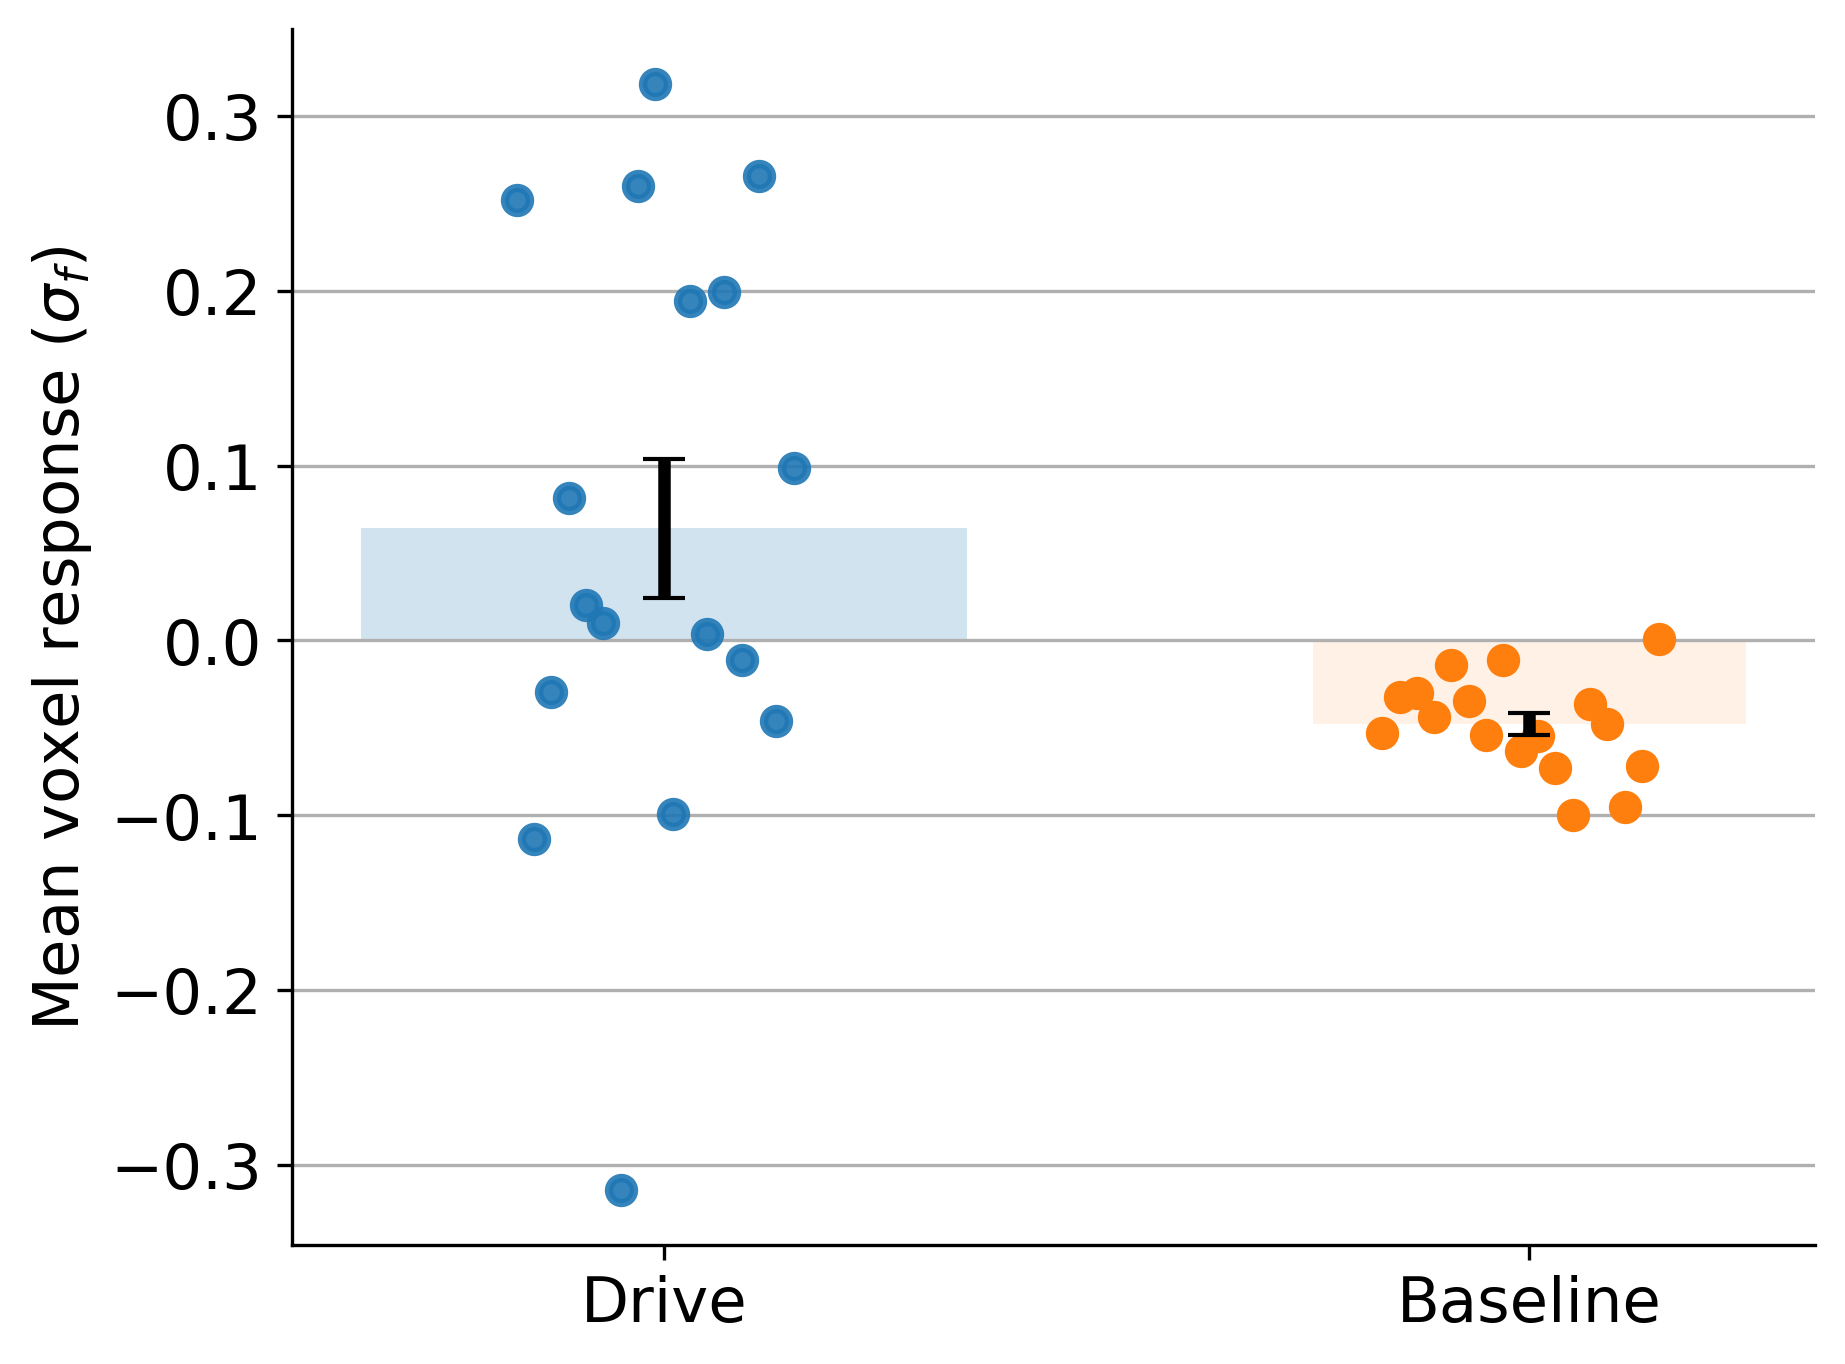

In [5]:
# calculate means
use_clusters = False
m1 = m[use_clusters]
diag_means = np.diag(m1)
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / len(diag_means))
sasc.viz.barplot_default([diag_means], [off_diag_means],
                         pilot_name, expls, annot_points=False)
joblib.dump({'diag_means': diag_means,
            'off_diag_means': off_diag_means}, join(config.RESULTS_DIR, 'processed', pilot_name.replace('_story_data.pkl', '_default_means.pkl')))

### Relationship between different voxels

<>:15: DeprecationWarning: invalid escape sequence '\s'
<>:15: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_1517143/2183783387.py:15: DeprecationWarning: invalid escape sequence '\s'
  m_plot, clab="Mean response ($\sigma$)", clab_size='large')


01 clothing
02 college days
03 communication
04 family and friends
05 family relationships
06 food
07 food and drink
08 locations
09 lonelineness
10 movement
11 numbers
12 physical contact
13 physical movement
14 repeated words
15 speaking
16 specific times
17 violence and injury


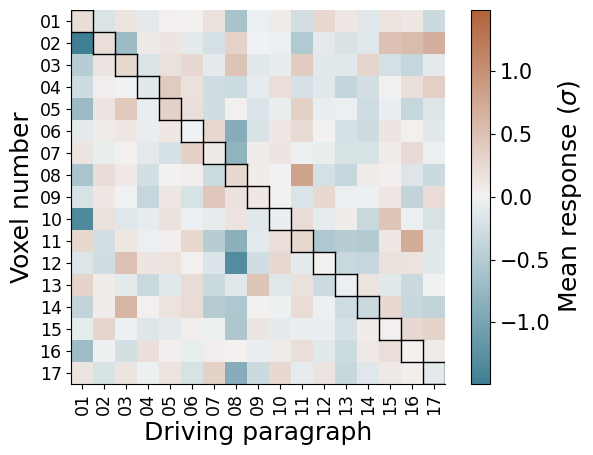

In [6]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)

s = 'small'
# expls_order = analyze_helper.sort_expls_semantically(expls, device='cuda')
expls_order = np.argsort(expls)
if pilot_name == 'pilot_story_data.pkl':
    expls_order = expls_order[[15, 7, 11, 14, 3,
                               12, 4, 1, 2, 0, 13, 6, 5, 16, 10, 9, 8]]
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
sasc.viz.imshow_diverging(
    m_plot, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel("Driving paragraph",  # \n(Ideally, diagonal should be brighter)",
           fontsize='large')

# plt.ylabel("Voxel", fontsize='x-small')
# labs = expls[expls_order]

plt.ylabel("Voxel number", fontsize='large')
labs = [f'{i + 1:02d}' for i in range(len(expls_order))]
for i in range(len(labs)):
    print(labs[i], expls[expls_order[i]])

plt.yticks(labels=labs, ticks=np.arange(
    len(expls)), fontsize=s)
plt.xticks(labels=labs, ticks=np.arange(
    len(expls)), rotation=90, fontsize=s)
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_default_heatmap.pdf'), bbox_inches='tight')
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

### Story-level differences

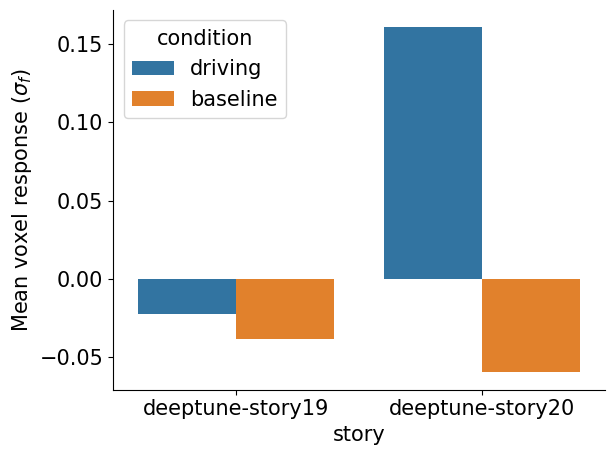

In [7]:
def get_story_df(mats1, melt=False):
    d = defaultdict(list)
    story_names = resp_np_files
    for i in range(len(mats1)):
        m = mats1[i]
        d['driving'].append(np.nanmean(np.diag(m)))
        d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
        d['story'].append(story_names[i].replace('.npy', ''))
    d = pd.DataFrame.from_dict(d)
    if melt:
        d = d.melt(id_vars='story', value_vars=[
            'driving', 'baseline'], var_name='condition', value_name='mean')
        d = d[d.condition == 'driving']
    return d


use_clusters = False
mats1 = mats[use_clusters]
story_scores_df = get_story_df(mats1)
joblib.dump(story_scores_df, join(config.RESULTS_DIR, 'processed',
            pilot_name.replace('_story_data.pkl', '_default_story_scores.pkl')))

sasc.viz.stories_barplot(story_scores_df)

# Extra analysis for UTS02

### Clusters vs non-clusters

In [ ]:
sns.color_palette("Blues", 2)[0]

In [ ]:
assert pilot_name == 'pilot_story_data.pkl'
df1 = get_story_df(mats[False], melt=True)
df1['Setting'] = 'Single voxel'
df2 = get_story_df(mats[True], melt=True)
df2['Setting'] = 'Voxel cluster'
df = pd.concat([df1, df2])
df['story'] = df['story'].str.replace('GenStory', '')

sns.barplot(data=df, x='story', y='mean',
            hue='Setting',
            width=0.8,
            palette=[sns.color_palette("Blues", 3)[0], 'lightgray'],
            )
plt.xlabel("Story")
plt.ylabel('Mean driving voxel response ($\sigma$)')
plt.savefig(join(config.RESULTS_DIR, 'figs/misc',
            'cluster_vs_single_default_story_breakdown.pdf'))

### Good prompt vs bad prompt

In [ ]:
assert pilot_name == 'pilot_story_data.pkl'
df = get_story_df(mats[False], melt=True)
good_prompt = ['GenStory2', 'GenStory3', 'GenStory4']
df['Prompt'] = df.apply(lambda x: x['story'] in good_prompt, axis=1)
df['Prompt'] = df['Prompt'].map(
    {True: 'Prompt version 1', False: 'Prompt version 0'})
df = df.sort_values(by='Prompt', ascending=False)
df['story'] = df['story'].str.replace('GenStory', '')


# shade bars by prompt version
offset = 0
xticklabels = []
for i, prompt in enumerate(df['Prompt'].unique()):
    d = df[df['Prompt'] == prompt]
    d = d.sort_values('story')
    plt.bar(np.arange(len(d)) + offset, d['mean'], label=prompt,
            color=sns.color_palette("Blues", 3)[0], hatch='' if i == 0 else '//')
    xticklabels += d['story'].tolist()
    offset += len(d)
plt.xticks(np.arange(len(xticklabels)), xticklabels)

plt.legend()
plt.xlabel("Story")
plt.ylabel('Mean driving voxel response ($\sigma$)')
plt.savefig(join(config.RESULTS_DIR, 'figs/misc',
            'prompt_default_story_breakdown.pdf'))

### Voxel-level differences

In [ ]:
# add stats
def save_voxel_scores(m, rows, pilot_name):
    rows["driving_score"] = np.diag(m[False])
    rm = pd.read_pickle(join(config.RESULTS_DIR, 'sasc', "fmri_results_merged.pkl")).sort_values(
        by=["stability_score"], ascending=False
    )
    for k in ["fmri_test_corr_llama", "top_score_normalized_llama"]:
        rows[k] = rows.apply(
            lambda row: rm[
                (rm.module_num == row.module_num) & (rm.subject == row.subject)
            ].iloc[0][k],
            axis=1,
        ).values
    cols = ["expl", "driving_score", "stability_score", "top_score_normalized", "top_score_normalized_llama",
            "fmri_test_corr", "fmri_test_corr_llama", "module_num"]
    voxel_scores = rows[cols]
    joblib.dump(voxel_scores, join(config.RESULTS_DIR, 'processed',
                pilot_name.replace('_story_data.pkl', '_default_voxel_scores.pkl')))


save_voxel_scores(m, rows, pilot_name)

In [ ]:
sns.pairplot(rows[cols + ["expl"]], kind="reg")  # , hue='expl')